## Install and Import

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [3]:
!pip install transformers pytorch-nlp

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
#from pytorch_pretrained_bert import BertConfig
from pytorch_pretrained_bert import BertAdam
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, AdamW
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pickle
import string
% matplotlib inline

Using TensorFlow backend.


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Load Dataset

In [0]:
# Upload the train file from your local drive; ibcData.pkl 
from google.colab import files
uploaded = files.upload()

In [0]:
# Upload the train file from your local drive; treeUtil.py
from google.colab import files
uploaded = files.upload()

In [0]:
torch.cuda.empty_cache()

In [0]:
import pickle

if __name__ == '__main__':
    [lib, con, neutral] = pickle.load(open('ibcData.pkl', 'rb'))

In [0]:
# Transform data

sentences_lib = []
sentences_con = []
sentences_neutral = []
        
for tree in lib:
    sentences_lib.append(tree.get_words())
    
for tree in con:
    sentences_con.append(tree.get_words())

for tree in neutral:
    sentences_neutral.append(tree.get_words())
    

#Labels are set such that 0 is liberal, 1 conservative, and 2 is neutral
d = {'sentences': [sentences_lib, sentences_con, sentences_neutral], 
     'labels': [[0]*len(sentences_lib),                                                    
                [1]*len(sentences_con),                                                
                [2]*len(sentences_neutral)]}

d = {'sentences': [sentences_lib, sentences_con], 
     'labels': [[0]*len(sentences_lib),                                                    
                [1]*len(sentences_con)]}

df = pd.DataFrame(data=d)

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = [sentences_lib, sentences_con, sentences_neutral]
sentences = [sentences_lib, sentences_con]

sentences = [item for sublist in sentences for item in sublist]
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.labels.values
labels = [item for sublist in labels for item in sublist]

In [11]:
len_sents = []
for sent in sentences:
    len_sents.append(len(sent))
df_len = pd.DataFrame({'length':len_sents})
sum(df_len.length>512)

1

In [12]:
#Only one sentence with more than 512 characters (maximum accepted by BERT)
print (sentences[df_len[df_len.length>512].index.values[0]])
print (sentences[df_len[df_len.length>512].index.values[0]][:506]+' [SEP]')

[CLS] Between credit-card usage and using store-sponsored discount cards when purchasing groceries , people 's purchases at grocery stores can easily be monitored and citizens could easily be found in violation of a bureaucratic edict from Washington , D.C. Everyone old enough to remember the good old days of family physicians making house calls , spending a great deal of time with and getting to know the patient , and charging low fees to boot , is deeply and properly resentful of the current assembly-line care . [SEP]
[CLS] Between credit-card usage and using store-sponsored discount cards when purchasing groceries , people 's purchases at grocery stores can easily be monitored and citizens could easily be found in violation of a bureaucratic edict from Washington , D.C. Everyone old enough to remember the good old days of family physicians making house calls , spending a great deal of time with and getting to know the patient , and charging low fees to boot , is deeply and properly 

In [0]:
#We can see above that there is little difference for that sentence if we remove the last characters in order to achieve a maximum
#lenght of 512
sentences[df_len[df_len.length>512].index.values[0]] = sentences[df_len[df_len.length>512].index.values[0]][:506]+' [SEP]'

In [0]:
#Shuffle data
sentences_data, labels_data = shuffle(sentences, labels)

#Train set
sentences = sentences_data[0 : int(len(sentences_data) * .8)]
labels = labels_data[0 : int(len(labels_data) * .8)]

#Test set
sentences_test = sentences_data[int(len(sentences)) : int(len(sentences_data))]
labels_test = labels_data[int(len(labels)) : int(len(labels_data))]

In [0]:
# Using BertTokenizer to properly tokenize the data for BERT modeling 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, tokenize_chinese_chars=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [0]:
MAX_LEN = 128

# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [19]:
torch.cuda.empty_cache() 

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. (If custom, do: layer_norm_eps=1e-08,)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2,  hidden_act='gelu_new', 
                                                      output_attentions=True, output_hidden_states=True)

# Run model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-08, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-08, element

In [20]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0}
]

# Adam optimizer with a warmup rate of 0.1, and a learning rate of 1e-5
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=1e-5,
                     warmup=.1)


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

t_total value of -1 results in schedule not being applied


In [21]:
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 8

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoc

  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())    
    # Backward pass
    loss[0].backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss[0].item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask) 
    # Move logits and labels to CPU
    logits_pred = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits_pred, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.7007121450844265


Epoch:  12%|█▎        | 1/8 [00:41<04:53, 41.97s/it]

Validation Accuracy: 0.51
Train loss: 0.6940978708721343


Epoch:  25%|██▌       | 2/8 [01:23<04:11, 41.97s/it]

Validation Accuracy: 0.51
Train loss: 0.6988090035461244


Epoch:  38%|███▊      | 3/8 [02:05<03:29, 41.94s/it]

Validation Accuracy: 0.5431250000000001
Train loss: 0.6953810943024499


Epoch:  50%|█████     | 4/8 [02:47<02:47, 41.93s/it]

Validation Accuracy: 0.51
Train loss: 0.6948848799580619


Epoch:  62%|██████▎   | 5/8 [03:29<02:05, 41.90s/it]

Validation Accuracy: 0.51
Train loss: 0.692183065982092


Epoch:  75%|███████▌  | 6/8 [04:11<01:23, 41.88s/it]

Validation Accuracy: 0.51
Train loss: 0.6971676484459922


Epoch:  88%|████████▊ | 7/8 [04:53<00:41, 41.87s/it]

Validation Accuracy: 0.51
Train loss: 0.6788970508745739


Epoch: 100%|██████████| 8/8 [05:35<00:00, 41.89s/it]

Validation Accuracy: 0.49000000000000005


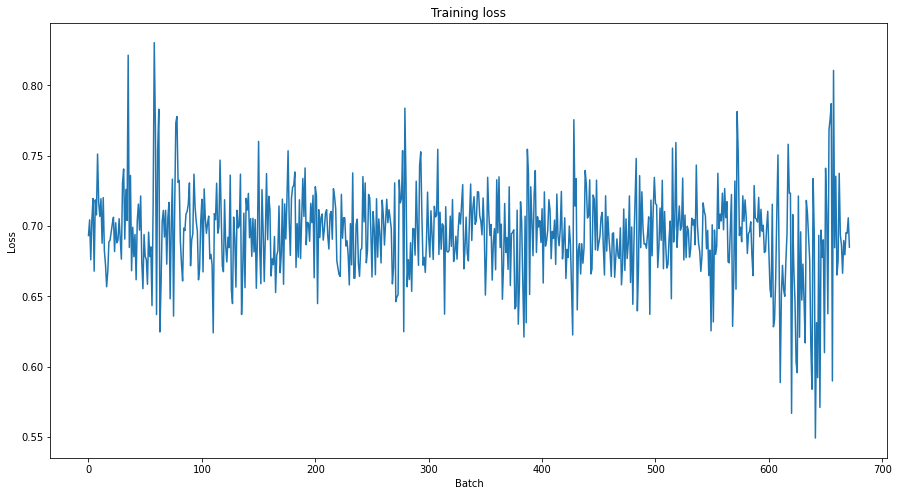

<Figure size 432x288 with 0 Axes>

In [23]:
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()
plt.savefig('Training_performance.png')

## Evaluation

In [0]:
# load test data
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test]
labels = labels_test

# tokenize test data
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# Set the maximum sequence length
#MAX_LEN = len(tokenized_texts[0])
#for i in range(1, len(tokenized_texts)):
#    if len(tokenized_texts[i]) > MAX_LEN:
#        MAX_LEN = len(tokenized_texts[i])

# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# create test tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Prediction on test set
# Put model in evaluation model
model.eval()
# Tracking variables 
predictions , true_labels, test_loss = [], [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits[0].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Flatten the predictions and true values for evaluation metrics
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [26]:
from sklearn.metrics import f1_score
f1_score(flat_predictions, flat_true_labels,average='macro')

0.3204856497098141

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(flat_predictions, flat_true_labels)

0.4624664879356568